In [1]:
import pandas as pd
import numpy as np
from recommender_metrics.plots import LongTailPlot, CoveragePlot, MarkPlot, MapkPlot
from recommender_metrics.metrics import mark, coverage, personalization, intra_list_similarity
import matplotlib.pyplot as plt

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [2]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [3]:
pop_movies = ratings.movieId.value_counts().head(10).index.tolist()

In [4]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [5]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


In [6]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [70]:
test = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
test = test[test.sum(axis=1)>0]
test.sample(5)

,Action,Romance,Western,Comedy,Crime
movieId,,,,,
131144,0,0,0,1,0
2890,1,0,0,0,0
2055,1,0,0,0,0
27642,0,0,0,0,1
7420,0,1,0,0,0


## Long Tail Plot Example

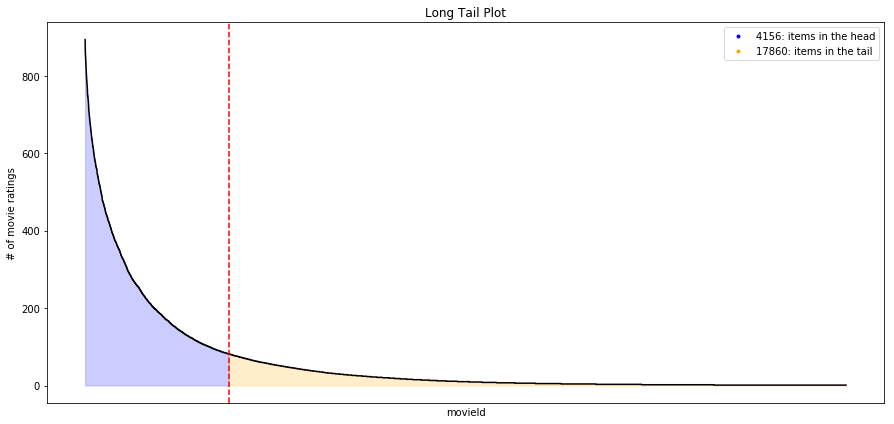

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
    
LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.8,
             x_labels=False)

## test/train split

In [8]:
# the test data contains 100 movies from each user that are rated greater than 3 stars
test_index = ratings.copy()
test_index = test_index.groupby('userId')
test_index = test_index.apply(lambda x: x.sample(min(100, len(x))))

test_index.drop(axis=1, columns="userId", inplace=True)
test_index.reset_index(inplace=True, drop=False)
test_index = test_index.level_1.values.tolist()

test_df = ratings.loc[test_index]
test = test_df.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recommender_metrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


,actual
userId,
156,"[5638, 6156, 3330, 3598, 3087, 4628, 2581, 412..."
208,"[517, 4103, 55820, 5135, 72720, 4117, 535, 338..."
359,"[4011, 37382, 3081, 1546, 1049, 3098, 541, 483..."
394,"[2054, 1035, 60943, 3091, 21, 4121, 2076, 541,..."
572,"[2, 39427, 54276, 1029, 37384, 33794, 42002, 5..."


In [9]:
train_long = ratings[~ratings.index.isin(test_index)].dropna()
train_long.head()

,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803
15921,156,5,3.0,1040944583
15922,156,6,4.0,1037822117


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [10]:
#make recommendations for all members in the test data

recs = []
for user in test.index.tolist():
    pop_predictions = pop_movies
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,pop_predictions
userId,,
156,"[5638, 6156, 3330, 3598, 3087, 4628, 2581, 412...","[296, 318, 356, 593, 480, 260, 110, 589, 2571,..."
208,"[517, 4103, 55820, 5135, 72720, 4117, 535, 338...","[296, 318, 356, 593, 480, 260, 110, 589, 2571,..."
359,"[4011, 37382, 3081, 1546, 1049, 3098, 541, 483...","[296, 318, 356, 593, 480, 260, 110, 589, 2571,..."
394,"[2054, 1035, 60943, 3091, 21, 4121, 2076, 541,...","[296, 318, 356, 593, 480, 260, 110, 589, 2571,..."
572,"[2, 39427, 54276, 1029, 37384, 33794, 42002, 5...","[296, 318, 356, 593, 480, 260, 110, 589, 2571,..."


In [11]:
actual = test.actual.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()

# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [83]:
#make recommendations for all members in the test data

recs = []
for user in test.index.tolist():
    random_predictions = pd.Series(train_long.movieId.unique()).sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_predictions'] = recs
test.head()

,Action,Romance,Western,Comedy,Crime,random_predictions
movieId,,,,,,
3,0,0,0,1,0,"[108151, 102852, 32770, 7080, 6586, 27189, 905..."
4,0,0,0,1,0,"[31737, 108819, 26694, 89582, 44663, 88740, 73..."
5,0,0,0,1,0,"[2563, 104335, 3407, 4, 99050, 2605, 80812, 21..."
6,1,0,0,0,0,"[100591, 74698, 8607, 5722, 6201, 3087, 2364, ..."
7,0,0,0,1,0,"[3378, 52995, 6255, 88493, 113636, 106762, 323..."


In [84]:
random_predictions = test.random_predictions.values.tolist()

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [14]:
train_pivot = train_long.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
user_index = train_pivot.index.tolist()
movie_index = train_pivot.columns.tolist()
train_pivot.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,131176,131231,131239,131241,131243,131248,131250,131252,131254,131256
userId,,,,,,,,,,,,,,,,,,,,,
156,5.0,5.0,0.0,3.0,3.0,4.0,4.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

#svd
U, sigma, Vt = svds(train_pivot, k=100) # k is the number of factors
eigvals = sigma**2 / np.cumsum(sigma)[-1]
eigvals = eigvals[::-1]
sigma = np.diag(sigma)

#reconstruct ratings matrix
cf_model = np.dot(np.dot(U, sigma), Vt) 
cf_model = pd.DataFrame(cf_model, index=user_index, columns=movie_index)

In [16]:
cf_model.head()

,1,2,3,4,5,6,7,8,9,10,...,131176,131231,131239,131241,131243,131248,131250,131252,131254,131256
156,3.177957,4.396834,1.084615,2.239511,1.779075,3.151380,3.623664,1.045843,1.525501,3.444393,...,0.008127,-0.005610,-0.014378,-0.014378,-0.014378,-0.014378,-0.014378,-0.014378,-0.014378,-0.014378
208,3.492607,0.287707,-0.137562,0.480639,-0.127609,1.463084,0.496015,-0.056589,0.252973,0.044338,...,0.014313,0.034297,-0.025579,-0.025579,-0.025579,-0.025579,-0.025579,-0.025579,-0.025579,-0.025579
359,4.365899,1.595487,0.275698,0.026416,0.544452,4.149262,0.983877,0.012946,0.396064,1.988424,...,-0.007279,-0.038532,0.013371,0.013371,0.013371,0.013371,0.013371,0.013371,0.013371,0.013371
394,3.760275,0.463533,0.226879,-0.028666,-0.265353,1.611357,0.045185,-0.130933,0.182503,0.583177,...,-0.033707,-0.060559,-0.021201,-0.021201,-0.021201,-0.021201,-0.021201,-0.021201,-0.021201,-0.021201
572,3.737946,1.895750,2.554096,-0.251839,2.355477,1.016846,0.766895,0.053434,0.152712,1.325933,...,0.055071,-0.020463,-0.012843,-0.012843,-0.012843,-0.012843,-0.012843,-0.012843,-0.012843,-0.012843


In [17]:
def get_users_predictions(user_id, n, model, train_long):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    rated_items_from_train = train_long.query('userId == @user_id').movieId.tolist()
    recommended_items = recommended_items[~recommended_items.index.isin(rated_items_from_train)]
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [18]:
get_users_predictions(156, 10, cf_model, train_long)

[2672, 3361, 3494, 4855, 3702, 4361, 1616, 1620, 2889, 1721]

In [19]:
#make recommendations for all members in the test data

recs = []
for user in user_index:
    cf_predictions = get_users_predictions(user, 10, cf_model, train_long)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

,actual,pop_predictions,random_predictions,cf_predictions
userId,,,,
156,"[5638, 6156, 3330, 3598, 3087, 4628, 2581, 412...","[296, 318, 356, 593, 480, 260, 110, 589, 2571,...","[1931, 3211, 100383, 4474, 337, 1037, 4034, 88...","[2672, 3361, 3494, 4855, 3702, 4361, 1616, 162..."
208,"[517, 4103, 55820, 5135, 72720, 4117, 535, 338...","[296, 318, 356, 593, 480, 260, 110, 589, 2571,...","[59315, 94896, 97304, 2650, 319, 7147, 3969, 1...","[3996, 515, 608, 1147, 1256, 2064, 1235, 1307,..."
359,"[4011, 37382, 3081, 1546, 1049, 3098, 541, 483...","[296, 318, 356, 593, 480, 260, 110, 589, 2571,...","[7748, 266, 6002, 78517, 2021, 3740, 81681, 10...","[47610, 36529, 1610, 6539, 2762, 1213, 34048, ..."
394,"[2054, 1035, 60943, 3091, 21, 4121, 2076, 541,...","[296, 318, 356, 593, 480, 260, 110, 589, 2571,...","[1372, 96966, 2580, 8977, 8978, 1004, 3916, 74...","[162, 1288, 111, 800, 1, 541, 2076, 903, 6440,..."
572,"[2, 39427, 54276, 1029, 37384, 33794, 42002, 5...","[296, 318, 356, 593, 480, 260, 110, 589, 2571,...","[2567, 8149, 1947, 30846, 58303, 2406, 6197, 1...","[33660, 33794, 3360, 6879, 1500, 32029, 440, 3..."


In [20]:
cf_predictions = test.cf_predictions.values.tolist()

# Recall

In [85]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

[0.0006216505894962488,
 0.0009378349410503752,
 0.0011450518042157914,
 0.0013620936048588782,
 0.001529296177206145,
 0.0016972132904608788,
 0.0018380799265043637,
 0.001961338233042413,
 0.0020792374827744604,
 0.002196064921145307]

In [86]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([mark(actual, random_predictions, k=K)])
random_mark

[2.1436227224008577e-05,
 4.823151125401929e-05,
 6.609503394069311e-05,
 7.681314755269738e-05,
 8.753126116470168e-05,
 8.753126116470168e-05,
 0.00010131169295156435,
 0.00010667074975756646,
 0.00011619796185712583,
 0.00012048520730192756]

In [87]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

[0.007931404072883171,
 0.014560557341907823,
 0.020741336191496963,
 0.026092354412290103,
 0.031155591282600925,
 0.036046623794212224,
 0.0406416322155872,
 0.04504543714591946,
 0.049318391772571836,
 0.053168338182003776]

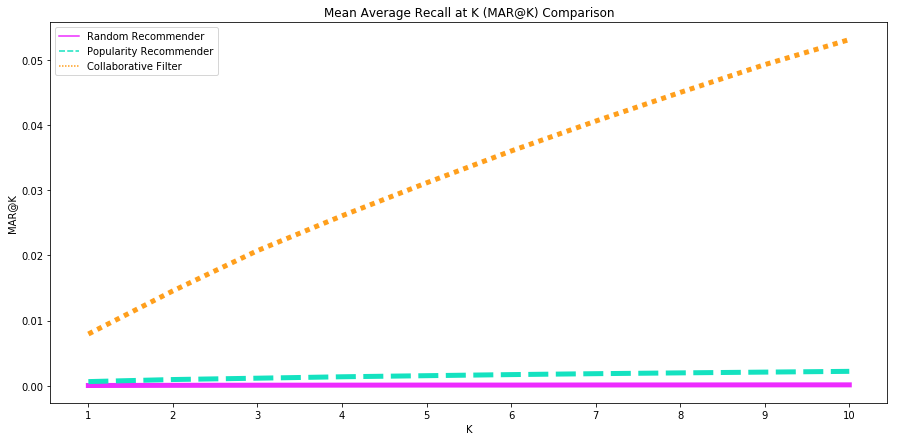

In [88]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
MarkPlot(mark_scores, model_names=names, k_range=index)

# Precision

In [112]:
import ml_metrics as metrics

In [113]:
pop_mapk = []
for K in np.arange(1, 11):
    pop_mapk.extend([metrics.mapk(actual, pop_predictions, k=K)])
pop_mapk

[0.06216505894962487,
 0.04689174705251876,
 0.03816839347385972,
 0.03405234012147195,
 0.030585923544122904,
 0.02828688817434798,
 0.026258284664348052,
 0.024516727913030164,
 0.023102638697494002,
 0.02196064921145307]

In [114]:
random_mapk = []
for K in np.arange(1, 11):
    random_mapk.extend([metrics.mapk(actual, random_predictions, k=K)])
random_mapk

[0.0021436227224008574,
 0.002411575562700965,
 0.002203167798023103,
 0.0019203286888174347,
 0.0017506252232940334,
 0.001458854352745028,
 0.001447309899308062,
 0.001333384371969581,
 0.001291088465079176,
 0.0012048520730192755]

In [115]:
cf_mapk = []
for K in np.arange(1, 11):
    cf_mapk.extend([metrics.mapk(actual, cf_predictions, k=K)])
cf_mapk

[0.7931404072883173,
 0.7280278670953912,
 0.6913778730498986,
 0.6523088603072525,
 0.6231118256520185,
 0.6007770632368702,
 0.58059474593696,
 0.5630679643239933,
 0.5479821308063537,
 0.5316833818200377]

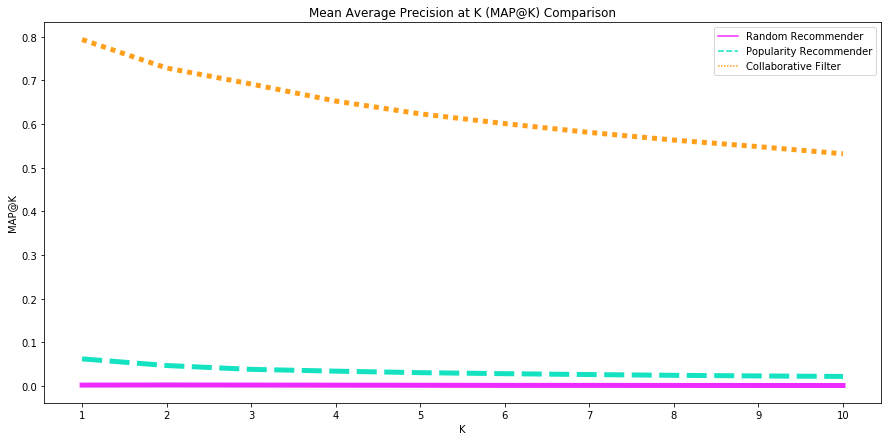

In [116]:
mapk_scores = [random_mapk, pop_mapk, cf_mapk]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
MapkPlot(mapk_scores, model_names=names, k_range=index)

# Coverage

In [94]:
catalog = train_long.movieId.unique().tolist()
random_coverage = coverage(random_predictions, catalog)
pop_coverage = coverage(pop_predictions, catalog)
cf_coverage = coverage(cf_predictions, catalog)

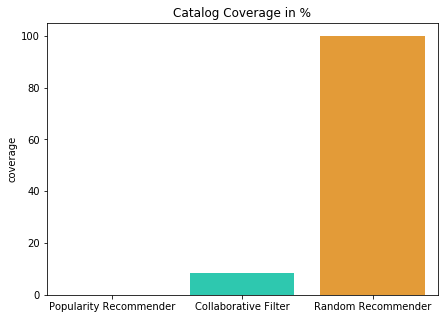

In [95]:
coverage_scores = [pop_coverage, cf_coverage, random_coverage]
model_names = ['Popularity Recommender', 'Collaborative Filter', 'Random Recommender']

fig = plt.figure(figsize=(7, 5))
CoveragePlot(coverage_scores, model_names)

In [96]:
coverage_scores

[0.05, 8.42, 99.93]

# Personalization

In [ ]:
random_personalization = personalization(predicted=random_predictions)
np.round(random_personalization,4)

In [ ]:
pop_personalization = personalization(predicted=pop_predictions)
np.round(pop_personalization,4)

In [ ]:
cf_personalization = personalization(predicted=cf_predictions)
np.round(cf_personalization,4)

# Intra-list Similarity

In [ ]:
random_ils = intra_list_similarity(predicted=random_predictions, feature_df=movies)
np.round(random_ils,4)

In [ ]:
pop_ils = intra_list_similarity(predicted=pop_predictions, feature_df=movies)
np.round(pop_ils,4)

In [ ]:
cf_ils = intra_list_similarity(predicted=cf_predictions, feature_df=movies)
np.round(cf_ils,4)